# Homework 1 in Software Applications with Artificial Intelligence (OSS-SAKI)
## by Stephanie Mehltretter

### Table of contents
1. [Evaluation of the data set](#1)
2. [Preprocessing of the data](#2)
3. [Model building](#3)
4. [Evaluation](#4)

<a name='1'></a>
### 1. Evaluation of the data set
<a name='1.1'></a>
#### 1.1 Import of libraries

In [1]:
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer
import re
from sklearn.metrics import accuracy_score
from statistics import mean
from stop_words import get_stop_words
from sklearn.model_selection import train_test_split
import numpy as np
from datetime import datetime
from sklearn.preprocessing import QuantileTransformer, RobustScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SVMSMOTE
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn
import warnings
warnings.filterwarnings("ignore")


#### 1.2 Data loading and analysis
Printing out an overview over the first six rows of the data set

In [2]:
df = pd.read_csv('TransactionClassificationDataSet.csv', sep=";")
df.head(6)


,Unnamed: 0,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
0,0,89990201.0,28.07.2016,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,25190001,2000.00,EUR,income
1,1,89990201.0,27.07.2016,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,DE31251900019123456780,VOHADE2HXXX,-670.00,EUR,living
2,2,89990201.0,21.07.2016,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,25190001,-70.00,EUR,private
3,3,89990201.0,20.07.2016,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,25190001,-73.21,EUR,standardOfLiving
4,4,89990201.0,18.07.2016,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,25125100,-363,EUR,leisure
5,5,89990201.0,15.07.2016,15.07.2016,Mieteinnahmen,Mietzuschuss End-To-End-Ref.: Notprovided Kund...,Isabel Anna,DE31251900019736000780,VOHADE2HXXX,200.00,EUR,finance


#### 1.3 Evaluate the number of distinct entries in the columns "Waehrung" and "Auftragskonto"

In [3]:
number_distinct_currencies = df.Waehrung.nunique()
print(number_distinct_currencies)

1


As the column "Waehrung" only consists of one entry, this column does not contain useful information for the model.

In [4]:
number_distinct_order_accounts = df.Auftragskonto.nunique()
print(number_distinct_order_accounts)

2


The column "Auftragskonto" contains two different values as well as NaN values. In the following, an evaluation is performed, whether the different values in the column "Auftragskonto" have a correlation with the column "label"

<AxesSubplot:xlabel='label'>

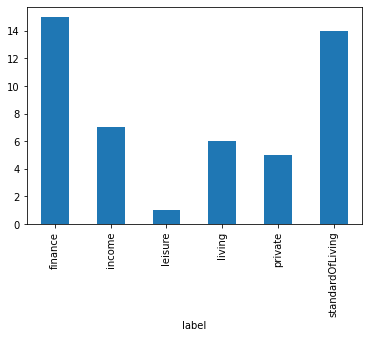

In [5]:
label_distribution_first_order_account = df.loc[(df['Auftragskonto'] == df['Auftragskonto'][1])]
label_distribution_first_order_account.groupby('label')['label'].count().plot.bar()


<AxesSubplot:xlabel='label'>

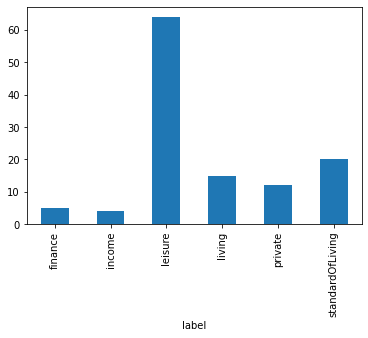

In [6]:
label_distribution_second_order_account = df.loc[(df['Auftragskonto'] == 89990210.0)]
label_distribution_second_order_account.groupby('label')['label'].count().plot.bar()

<AxesSubplot:xlabel='label'>

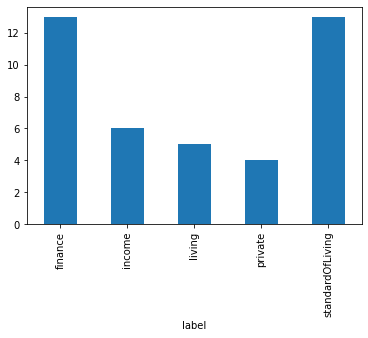

In [7]:
label_distribution_second_order_account = df.loc[(df['Auftragskonto'] != 89990210.0) & (df['Auftragskonto'] != 89990201.0)]
label_distribution_second_order_account.groupby('label')['label'].count().plot.bar()

According to the two bar chart above, the two entries in the column "Auftragskonto" do show a different distribution of the label values. This feature may be useful in the model building process. 

#### 1.4 Evaluate whether the content of the column "Buchungstag" and "Valutadatum" are always equal

In [8]:
equal_columns = np.where(df['Buchungstag'].equals(df['Valutadatum'])== False, "No", "Yes")
print("Columns 'Buchungstag' and 'Valutadatum' have identical values?: "+ str(equal_columns))

Columns 'Buchungstag' and 'Valutadatum' have identical values?: No


In [9]:
r = df.loc[(df['Buchungstag'] != df['Valutadatum'])]
r

,Unnamed: 0,Auftragskonto,Buchungstag,Valutadatum,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,BLZ,Betrag,Waehrung,label
125,125,89990210.0,11.02.2016,12.02.2016,Euro-Überweisung,"1,01E+13",Zalando Se,DE86210700200123010101,DEUTDEHH210,"-113,4",EUR,leisure


The columns "Buchungstag" and "Valutadatum" only differ in one entry and thus, the information gain is low by considering both columns in the model building process.

#### 1.5 Evaluate if an entry of the column "Kontonummer" always belongs to the same "BLZ" in our data set

In [10]:
df1 = df[['BLZ', 'Kontonummer']]
df2 = df1.drop_duplicates()
w = np.all(df2.groupby('Kontonummer')['BLZ'].count()==1)
print("The statement, that all entries of the column 'Kontonummer' have the same BLZ is " + str(w).lower() +".")


The statement, that all entries of the column 'Kontonummer' have the same BLZ is true.


Thus, it is sufficient to only use the column "Kontonummer" in the model building process instead of both.

<a name='1.6'></a>
#### 1.6 Analysis of the class balance/ imbalance
Class imbalance may lead to poor classification performance on test samples belonging to a class that is barly represented in the training data set. The ML model performs better on test data belonging to a frequently represented class within the training data set. The following plot shows the distribution of the class labels in the data set:

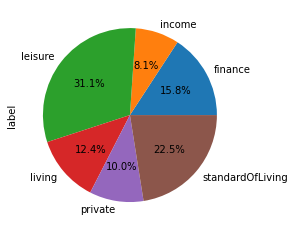

In [11]:
data = df.groupby("label")['label'].count()
data.plot.pie(autopct="%.1f%%");

As there are more frequent class occurences, e.g., standardOfLiving and leisure, and less frequent one like income and private, a rebalancing of the classes is performed in the preprocessing. 

<a name='2'></a>
### 2. Preprocessing of the data
In this section, the provided data is preprocessed for the use in the following training process.

#### 2.1 Removal of columns with high data sparsity
As recognized above, the columns "Valuatadatum" and "Waehrung" do not provide a significant information gain. Moreover, the first column of the dataset (referred to by "Unnamed: 0" in the dataframe) is just an increasing numeration and also does not contain relevant information. 

In [12]:
df.drop(columns=['Waehrung','Valutadatum','Unnamed: 0','BLZ'])

,Auftragskonto,Buchungstag,Buchungstext,Verwendungszweck,Beguenstigter/Zahlungspflichtiger,Kontonummer,Betrag,label
0,89990201.0,28.07.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,2000.00,income
1,89990201.0,27.07.2016,Miete,Byladem1Sbt De12773501123456789889 Miete Beuth...,Georg Tasche,DE31251900019123456780,-670.00,living
2,89990201.0,21.07.2016,Bargeld,"21.07/16.34Uhr Nuernberg All Eur 70,00 Geb.Eur...",Bargeld,9999900780,-70.00,private
3,89990201.0,20.07.2016,Lebensmittel / Getraenke,2831 Edeka Neubauer Nuernb.//Nuernb 2016-07-20...,Kartenzahlung,9736000780,-73.21,standardOfLiving
4,89990201.0,18.07.2016,Spontanausgabe,Amazon,neue Playstation,9988776655,-363,leisure
...,...,...,...,...,...,...,...,...
204,NaN,15.02.2016,Mieteinnahmen,Mietzuschuss End-To-End-Ref.: Notprovided Kund...,Isabel Anna,DE31251900019736000780,200.00,finance
205,NaN,02.02.2016,Geldanlage,Ccbade31Xxx De71310108339900123456 Sparen End-...,Michael Koffer,DE69790800529736000780,-300.00,finance
206,NaN,28.01.2016,Lohn / Gehalt,Gehalt Adorsys GmbH & Co. KG End-To-End-Ref.: ...,Adorsys GmbH & Co. KG,7807800780,2000.00,income
207,NaN,28.01.2016,Geldanlage,Ssknde77Xxx De41760501010012345675 Einmalspare...,Christina Jung,DE31251900019736333780,-4000.00,finance


#### 2.2 Extracting the main information, i.e., the weekday of the booking, from the column "Buchungstag"
Therefore, the weekdays are enumerated accouring to the ISO standard 8601.

In [13]:
df.Buchungstag = df.Buchungstag.apply(lambda x: datetime.strptime(str(x), '%d.%m.%Y'))
df.Buchungstag = df.Buchungstag.apply(lambda x: x.isoweekday())

In the following pie chart, the distribution of the ISO standardized entries of column "Buchungstag" is visualized.

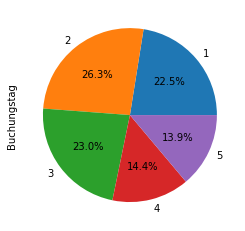

In [14]:
data = df.groupby("Buchungstag")['Buchungstag'].count()
data.plot.pie(autopct="%.1f%%");

Next, it is visualized, how many different data set entries have the same label and are executed on the same weekday.

<AxesSubplot:xlabel='Buchungstag,label'>

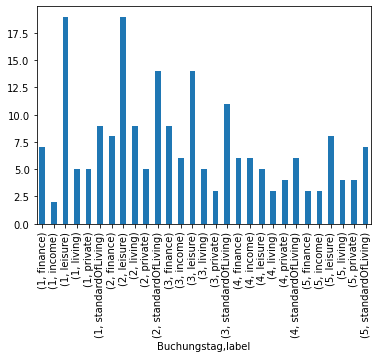

In [15]:
df.groupby(['Buchungstag', 'label'])['label'].count().plot.bar()

#### 2.3 Unification of the decimal separator of the entries of the column "Betrag"
Conversion of the decimal separator ',' to '.'.

In [16]:
df.Betrag = df['Betrag'].apply(lambda x: float(str(x).replace(',','.')))

In the following, the number of different values of the column "Betrag" grouped by the labels is visualized.

label
finance             33
income              17
leisure             65
living              26
private             21
standardOfLiving    47
Name: Betrag, dtype: int64

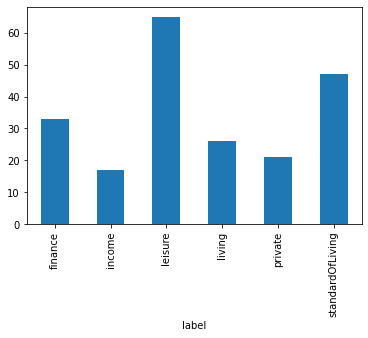

In [17]:
df.groupby(['label'])['Betrag'].count().plot.bar()
df.groupby(['label'])['Betrag'].count()

#### 2.4 Preprocessing of the text columns
In the following, the columns "Beguenstigter/Zahlungspflichtiger", "Buchungstext" and "Verwendungszweck" are cleaned from typical stopwords that typically do not contain relevant information for the ML model.

**Stopwords:** The package stop-words provides lists of stopwords for German and English, that are both considered. Apart from that, the English stopword list is extended by typical English stopwords that were not yet in the package's stopword list.

Moreover, the text entries are converted to a lowercase representation and stored as a matrix of token counts calculated by CountVectorizer.

In [18]:
custom_stop_words = ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn']
all_custom_stop_words = get_stop_words('german') + get_stop_words('english') + custom_stop_words #+ stop_words

def preprocess_text_data(betrag_free):
    count_vectorizer = CountVectorizer(lowercase=True, stop_words=all_custom_stop_words)
    if betrag_free:
        count_vectorizer.fit(df['accumulated_data_without_betrag'])
        vectorized_messages = count_vectorizer.transform(df['accumulated_data_without_betrag'])
    else:
        count_vectorizer.fit(df['accumulated_data'])
        vectorized_messages = count_vectorizer.transform(df['accumulated_data'])
    
    count_vect_df = pd.DataFrame(vectorized_messages.todense(), columns=count_vectorizer.get_feature_names())
    count_vect_df.loc[:, 'label'] = pd.DataFrame(df['label'])

    vectorized_messages = vectorized_messages.toarray()

    #print(vectorized_messages)
    y = count_vect_df.label
    X = count_vect_df.drop('label', axis=1)
    return (X, y, vectorized_messages)

#### 2.5 Split data set into a training and a test data set with a ratio of 80:20

In [25]:
def split_into_train_test_data():
    train, test, trainy, testy = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y.values)
    return (train, test, trainy, testy)

#### 2.6 Rebalance the training data set
As evaluated in [1.6](#1.6), the data set has a class imbalance. The following method minimizes this class imbalance:

In [26]:
def rebalance_training_data():
    X_rebalanced, y_rebalanced = SVMSMOTE().fit_resample(train, trainy)
    return (X_rebalanced, y_rebalanced)

The following pie chart visualizes the rebalanced training data:

<AxesSubplot:ylabel='label'>

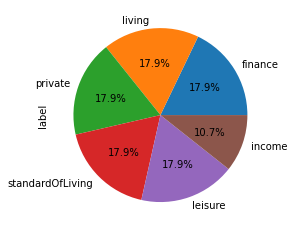

In [27]:
# Extracting the relevant columns of the data set
with pd.option_context('mode.chained_assignment', None):
    df.loc[:, 'accumulated_data'] = pd.DataFrame(df['Buchungstag'].astype('str')+df['Auftragskonto'].astype('str')+df['Beguenstigter/Zahlungspflichtiger']+df['Buchungstext']+df['Verwendungszweck']+','+df['Kontonummer'].astype('str'), columns=['Output']).apply(lambda x: ' '.join(x), axis=1)
# Extracting preprocessed text data
X, y, vectorized_messages = preprocess_text_data(betrag_free=False)
# Splitting into training and test data set
train, test, trainy, testy = split_into_train_test_data()
# Minimizing the class imbalance
X_rebalanced, y_rebalanced = rebalance_training_data()
y_rebalanced.value_counts().plot.pie(autopct="%.1f%%")

<a name='3'></a>
### 3. Model building
Here two Gaussian Naive Bayes classifiers are trained. 

In [42]:
number_of_iterations = 50
copy = []
accuracy_scores_rebalanced = []
accuracy_scores_imbalanced = []
accuracy_scores_betrag_free = []

for i in range(0,number_of_iterations):
    # Extracting the relevant columns of the data set
    with pd.option_context('mode.chained_assignment', None):
        df.loc[:, 'accumulated_data'] = pd.DataFrame(df['Betrag'].astype('str')+df['Buchungstag'].astype('str')+df['Auftragskonto'].astype('str')+df['Beguenstigter/Zahlungspflichtiger']+df['Buchungstext']+df['Verwendungszweck']+df['Kontonummer'].astype('str'), columns=['Output']).apply(lambda x: ' '.join(x), axis=1)
        df.loc[:, 'accumulated_data_without_betrag'] = pd.DataFrame(df['Buchungstag'].astype('str')+df['Auftragskonto'].astype('str')+df['Beguenstigter/Zahlungspflichtiger']+df['Buchungstext']+df['Verwendungszweck']+df['Kontonummer'].astype('str'), columns=['Output']).apply(lambda x: ' '.join(x), axis=1)

    # Extracting preprocessed text data
    X, y, vectorized_messages = preprocess_text_data(betrag_free = False)
    # Splitting into training and test data set
    train, test, trainy, testy = split_into_train_test_data()
    # Minimizing the class imbalance
    X_rebalanced, y_rebalanced = rebalance_training_data()
   
    # Creating and training a Gaussian Naive Bayes model with the rebalanced training data
    gnb = GaussianNB()
    gnb = gnb.fit(X_rebalanced, y_rebalanced)
    # Creating and training a Gaussian Naive Bayes model with the imbalanced training data
    gnb_imbalanced = GaussianNB()
    gnb_imbalanced = gnb_imbalanced.fit(train, trainy)

    # Predicting the test labels 
    result = gnb.predict(test)
    result_imbalanced = gnb_imbalanced.predict(test)

    # Not considering column Betrag
    X_betrag_free, y_betrag_free, vectorized_messages_betrag_free = preprocess_text_data(betrag_free = True)
    # Splitting into training and test data set
    train_betrag_free, test_betrag_free, trainy_betrag_free, testy_betrag_free = split_into_train_test_data()
    # Minimizing the class imbalance
    X_rebalanced_betrag_free, y_rebalanced_betrag_free = rebalance_training_data()
    gnb_betrag_free = GaussianNB()
    gnb_betrag_free = gnb_betrag_free.fit(X_rebalanced_betrag_free, y_rebalanced_betrag_free)
    result_betrag_free = gnb_betrag_free.predict(test)

    
    # Calculating the accuracy scores
    accuracy_score_rebalanced = accuracy_score(result, testy.tolist())
    accuracy_score_imbalanced = accuracy_score(result_imbalanced, testy.tolist())
    accuracy_score_betrag_free = accuracy_score(result_betrag_free, testy.tolist())

    accuracy_scores_rebalanced.append(accuracy_score_rebalanced)
    accuracy_scores_imbalanced.append(accuracy_score_imbalanced)
    accuracy_scores_betrag_free.append(accuracy_score_betrag_free)    

<a name='4'></a>
### 4. Evaluation
To examine the performance of the trained ML models, the mean crossvalidation_score and the mean accuracy are calculated.

In [43]:
print(f"mean accuracy score (rebalanced training data):\t{mean(accuracy_scores_rebalanced)}")
print(f"mean accuracy score (imbalanced training data):\t{mean(accuracy_scores_imbalanced)}")
print(f"mean accuracy score (rebalanced training data without column Betrag):\t{mean(accuracy_scores_betrag_free)}")

mean accuracy score (rebalanced training data):	0.8990476190476191
mean accuracy score (imbalanced training data):	0.8980952380952381
mean accuracy score (rebalanced training data without column Betrag):	0.8995238095238095


The mean accuracy score of the Gaussian Naive Bayes trained on the rebalanced is slightly better than the mean accuracy score of the Gaussian Naive Bayes trained on the imbalanced data set.

As the classifiers deal with a multinomlial problem, a confusion matrix is a helpful matrix for evaluating the precision and recall as well the f1-score of the classifiers on the separate classes. Also the weighted mean precision, recall and f1-score are of interest.

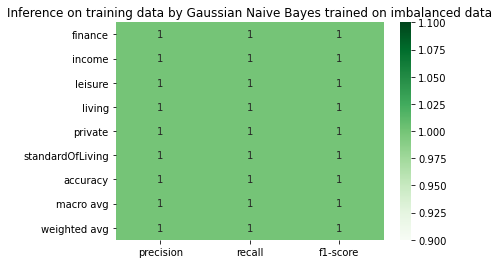

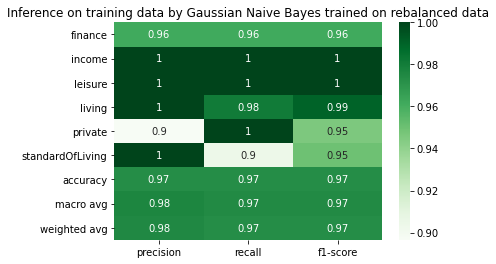

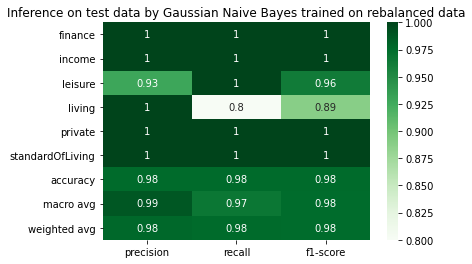

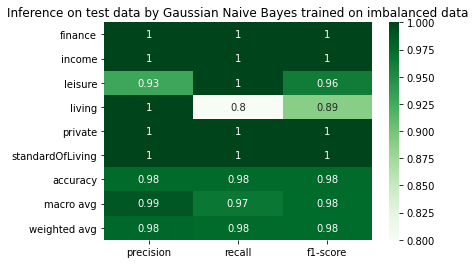

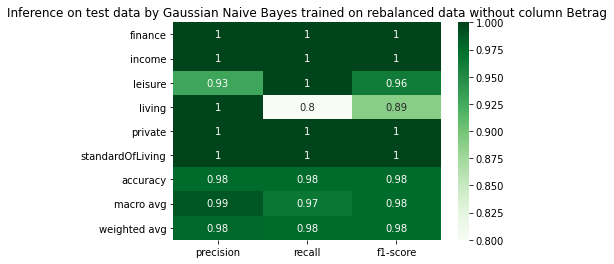

In [45]:
clf_report = classification_report(trainy, gnb_imbalanced.predict(train), output_dict=True)
seaborn.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, color='green', cmap=plt.cm.Greens)
plt.title('Inference on training data by Gaussian Naive Bayes trained on imbalanced data')
plt.show()

clf_report = classification_report(y_rebalanced, gnb.predict(X_rebalanced), output_dict=True)
seaborn.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, color='green', cmap=plt.cm.Greens)
plt.title('Inference on training data by Gaussian Naive Bayes trained on rebalanced data')
plt.show()


clf_report = classification_report(testy, result, output_dict=True)
seaborn.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, color='green', cmap=plt.cm.Greens)
plt.title('Inference on test data by Gaussian Naive Bayes trained on rebalanced data')
plt.show()

clf_report = classification_report(testy, result_imbalanced, output_dict=True)
seaborn.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, color='green', cmap=plt.cm.Greens)
plt.title('Inference on test data by Gaussian Naive Bayes trained on imbalanced data')
plt.show()

clf_report = classification_report(testy, result_betrag_free, output_dict=True)
seaborn.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True, color='green', cmap=plt.cm.Greens)
plt.title('Inference on test data by Gaussian Naive Bayes trained on rebalanced data without column Betrag')
plt.show()

As expected, the Gaussian Naive Bayes trained on the imbalanced data performs overfitting on the imbalanced training data set and achived an f1-score of 100%. According to the confusion matrices, the weighted average of the f1-score is 98%. Also, it does not seem to make a difference whether class rebalancing is used.  